In [1]:
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing, radius_graph, knn_graph
from torch_geometric.utils import remove_self_loops
from torch_scatter.scatter import scatter
from torch_scatter import scatter_min, scatter_max
from torch_cluster import knn
import matplotlib.pyplot as plt
from torch_cluster import fps
import pandas as pd
from models.gpgin import ConvLayer, MLP
from torch.nn.functional import silu
from torch_geometric.typing import (
    Adj,
    OptTensor,
    SparseTensor,
    pyg_lib,
    torch_sparse,
)
from typing import Tuple, List, Dict, Union
from pprint import pprint
from torch_geometric.data import Data, DataListLoader, Dataset, InMemoryDataset, Batch
from torch_geometric.loader import DataListLoader, DataLoader
from torch_geometric.nn import *
from torch_geometric.utils import to_dense_adj, to_dense_batch, add_self_loops, remove_self_loops
from torch_geometric.nn.conv import MessagePassing
import torch
from torch import nn
import rdkit
from tqdm.auto import tqdm
import itertools
from rdkit import Chem
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from rdkit import RDLogger

from copy import deepcopy
#from torch.utils.data import Dataset, DataLoader
from typing import Tuple, List, Dict, Union
from torch import Tensor
from torch_geometric.nn import MessagePassing, radius_graph
from torch_geometric.utils import add_self_loops, degree
from torch_scatter import scatter
from torch_geometric.typing import (
    Adj,
    OptTensor,
    SparseTensor,
    pyg_lib,
    torch_sparse,
)
from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)
from rdkit import Chem
import os
# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
cuda=torch.device('cuda') if torch.cuda.is_available() else 'cpu'
import sascorer
#torch.set_default_dtype(torch.float64)
from models import *
from rdkit.Chem.Crippen import MolLogP
from typing import List
from prolog import *
import torchlens as tl

In [2]:
class TrainingContext:
    def __init__(self, cls, *args, **kwargs):
        self.inner = cls(*args, **kwargs).to(cuda)
        self.name = cls.__name__
        self.optim = torch.optim.AdamW(self.inner.parameters())
        self.sched = torch.optim.lr_scheduler.ExponentialLR(self.optim, gamma=0.98)
        self.num_parameters = sum(map(torch.numel,self.inner.parameters()))
        self.train_loss_record = dict()
        self.test_loss_record = dict()
        self.results = list()
        self.total_iters = 0
        self.running_loss = 0
        self.best_eval_loss = 999999
        self.stopped = False
        self.batch_size=32
        self.train_loss_metric='DotProductLoss'
        self.eval_loss_metric='Multi-class Accuracy'
        self.last_target_name='correct object class'
        self.last_dataset_name='ModelNet40'
        self.training=True
    def save(self, prefix='saves'):
        save_model(
            self.name,
            self.inner,
            optimizer=self.optim,
            scheduler=self.sched,
            loss_record={
                'train':self.train_loss_record,
                'test':self.test_loss_record,
            },
            total_training_iters=self.total_iters,
            last_batch_size=self.batch_size,
            loss_metric={
                'train':'MSE',
                'test':'MAE',
            },
            last_target_name=self.last_target_name,
            last_dataset_name=self.last_dataset_name
        )
    @classmethod
    def load(cls, name, class_, prefix='saves', training=False, override=None):
        if override is None:
            override=dict()
        checkpoint=torch.load(os.path.join(prefix,name,'checkpoint.pth'))
        self=cls(class_,**dict(**checkpoint['config'],**override))
        self.inner.load_state_dict(checkpoint['model_state_dict'])
        self.optim.load_state_dict(checkpoint['optimizer_state_dict'])
        self.sched.load_state_dict(checkpoint['scheduler_state_dict'])
        self.total_iters=checkpoint['total_training_iters']
        self.batch_size=checkpoint['last_batch_size']
        self.train_loss_record=checkpoint['loss_record']['train']
        self.test_loss_record=checkpoint['loss_record']['test']
        self.best_eval_loss=min(self.test_loss_record.values())
        self.training=training
        return self
    

In [3]:
import inspect

def auto_save_hyperparams(init_fn):
    def wrapper(self, *args, **kwargs):
        # Bind the arguments to the function signature and apply defaults
        sig = inspect.signature(init_fn)
        bound_args = sig.bind(self, *args, **kwargs)
        bound_args.apply_defaults()
        # Save all parameters except 'self'
        self.hparams = {
            name: value 
            for name, value in bound_args.arguments.items() 
            if name != "self"
        }
        return init_fn(self, *args, **kwargs)
    return wrapper

In [4]:
from tqdm.auto import tqdm
import os
import torch
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader
import numpy as np

def read_off_fast(path):
    with open(path, 'r') as f:
        if f.readline().strip() != 'OFF':
            raise ValueError(f'Invalid OFF header: {path}')
        n_verts, n_faces, _ = map(int, f.readline().strip().split())
        data = np.loadtxt(f, max_rows=n_verts)  # FAST bulk load
    return torch.from_numpy(data).float()

class ModelNet40PyG(InMemoryDataset):
    def __init__(self, root_dir, split='train', fps_only=True, target_n_subsamples=1024, transform=None, pre_transform=None):
        self.root_dir = root_dir
        self.fps_only = fps_only
        self.target_n_subsamples = target_n_subsamples
        self.split = split
        self.the_raw_dir = os.path.join(self.root_dir,'raw')
        super().__init__(root_dir, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        # Required but not used; raw data lives in category folders
        return []

    @property
    def processed_file_names(self):
        return [f'modelnet40_{self.split}.pt']

    def download(self):
        # Assume files already downloaded/unzipped in root_dir
        pass

    def process(self):
        data_list = []
        classes = sorted(os.listdir(self.the_raw_dir))
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        for cls in tqdm(classes, smoothing=0.0, dynamic_ncols=True):
            split_dir = os.path.join(self.the_raw_dir, cls, self.split)
            if not os.path.isdir(split_dir):
                continue
            label = class_to_idx[cls]
            for fname in tqdm(os.listdir(split_dir), desc=cls, smoothing=0.0, dynamic_ncols=True):
                if fname.endswith('.off'):
                    path = os.path.join(split_dir, fname)
                    pos = read_off_fast(path)  # (N, 3)
                    data = Data(pos=pos, y=torch.tensor([label], dtype=torch.long))
                    data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [5]:
from tqdm.auto import tqdm
import os
import torch
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader
import numpy as np

def read_off_fast(path):
    with open(path, 'r') as f:
        if f.readline().strip() != 'OFF':
            raise ValueError(f'Invalid OFF header: {path}')
        n_verts, n_faces, _ = map(int, f.readline().strip().split())
        data = np.loadtxt(f, max_rows=n_verts)  # FAST bulk load
    return torch.from_numpy(data).float()

class ModelNet40PyGSubSample(InMemoryDataset):
    def __init__(self, root_dir, split='train', fps_only=True, target_n_subsamples=1024, transform=None, pre_transform=None):
        self.root_dir = root_dir
        self.fps_only = fps_only
        self.target_n_subsamples = target_n_subsamples
        self.split = split
        self.the_raw_dir = os.path.join(self.root_dir,'raw')
        super().__init__(root_dir, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        # Required but not used; raw data lives in category folders
        return []

    @property
    def processed_file_names(self):
        return [f'modelnet40_subsample_{self.split}.pt']

    def download(self):
        # Assume files already downloaded/unzipped in root_dir
        pass

    def process(self):
        data_list = []
        classes = sorted(os.listdir(self.the_raw_dir))
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        for cls in tqdm(classes, smoothing=0.0, dynamic_ncols=True):
            split_dir = os.path.join(self.the_raw_dir, cls, self.split)
            if not os.path.isdir(split_dir):
                continue
            label = class_to_idx[cls]
            for fname in tqdm(os.listdir(split_dir), desc=cls, smoothing=0.0, dynamic_ncols=True):
                if fname.endswith('.off'):
                    path = os.path.join(split_dir, fname)
                    pos = read_off_fast(path)  # (N, 3)
                    pos = pos[torch.randperm(pos.size(0))[:1024]]
                    data=Data(pos=pos, y=torch.tensor([label], dtype=torch.long))
                    data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
    def __getitem__(self, idx):
        data = super().__getitem__(idx)
        return data

In [6]:
train = ModelNet40PyGSubSample('./data/uncompressed/ModelNet40/', split='train')
test = ModelNet40PyGSubSample('./data/uncompressed/ModelNet40/', split='test')

In [7]:
import torch
import heapq
from torch import nn
from typing import Optional


class OnlineQuantileEstimator(nn.Module):
    def __init__(self, quantile=0.95, max_bins=200):
        super().__init__()
        self.quantile = quantile
        self.max_bins = max_bins

        self.register_buffer("bin_edges", torch.empty(0))
        self.register_buffer("bin_counts", torch.empty(0))
        self.register_buffer("total_count", torch.tensor(0.0))

    def update(self, x: torch.Tensor):
        x = x.detach().flatten().to(self.bin_edges.device)
        new_edges, new_counts = torch.unique(x, return_counts=True)
        new_edges = new_edges.to(torch.float32)
        new_counts = new_counts.to(torch.float32)

        self.total_count += new_counts.sum()

        if self.bin_edges.numel() == 0:
            self.bin_edges = new_edges
            self.bin_counts = new_counts
        else:
            merged_edges, merged_counts = self._merge_histograms(
                self.bin_edges, self.bin_counts, new_edges, new_counts
            )
            if merged_edges.numel() > self.max_bins:
                merged_edges, merged_counts = self._reduce_bins(merged_edges, merged_counts)

            self.bin_edges = merged_edges
            self.bin_counts = merged_counts

    def _merge_histograms(self, edges1, counts1, edges2, counts2):
        edges = torch.cat([edges1, edges2])
        counts = torch.cat([counts1, counts2])
        sorted_edges, indices = torch.sort(edges)
        sorted_counts = counts[indices]
        unique_edges, inverse_idx = torch.unique_consecutive(sorted_edges, return_inverse=True)
        merged_counts = torch.zeros_like(unique_edges)
        merged_counts.index_add_(0, inverse_idx, sorted_counts)
        return unique_edges, merged_counts

    def _reduce_bins(self, edges, counts):
        edges = edges.tolist()
        counts = counts.tolist()
        alive = [True] * len(edges)
    
        def push_pair(i):
            if i < len(edges) - 1 and alive[i] and alive[i + 1]:
                diff = edges[i + 1] - edges[i]
                heapq.heappush(heap, (diff, i))
    
        heap = []
        for i in range(len(edges) - 1):
            push_pair(i)
        print('i')
        while sum(alive) > self.max_bins:
            print(sum(alive), len(heap))
            while heap:
                cost, i = heapq.heappop(heap)
                print(i,'<',len(edges) - 1,'and',alive[i],'and',alive[i + 1])
                if i < len(edges) - 1 and alive[i] and alive[i + 1]:
                    break
            else:
                # Rebuild heap if no valid pair is left
                heap = []
                for i in range(len(edges) - 1):
                    push_pair(i)
                continue
    
            # Merge bins i and i+1
            c1, c2 = counts[i], counts[i + 1]
            v1, v2 = edges[i], edges[i + 1]
            new_count = c1 + c2
            new_edge = (v1 * c1 + v2 * c2) / new_count
    
            edges[i] = new_edge
            counts[i] = new_count
            alive[i + 1] = False
    
            if i > 0:
                push_pair(i - 1)
            push_pair(i)
        print('done')
    
        final_edges = [e for i, e in enumerate(edges) if alive[i]]
        final_counts = [c for i, c in enumerate(counts) if alive[i]]
    
        return torch.tensor(final_edges, dtype=torch.float32, device=self.bin_edges.device), \
               torch.tensor(final_counts, dtype=torch.float32, device=self.bin_counts.device)


    def forward(self, x: Optional[torch.Tensor] = None):
        if self.bin_edges.numel() == 0 or self.total_count == 0:
            return torch.full_like(x, float('nan')) if x is not None else torch.tensor(float('nan'))

        if x is None:
            cum_counts = torch.cumsum(self.bin_counts, dim=0)
            target = self.total_count * self.quantile
            idx = torch.searchsorted(cum_counts, target, right=False)
            idx = torch.clamp(idx, 0, self.bin_edges.numel() - 1)
            return self.bin_edges[idx]

        x = x.to(self.bin_edges.device).flatten()
        bin_edges = self.bin_edges
        bin_counts = self.bin_counts
        cum_counts = torch.cumsum(bin_counts, dim=0)

        idx = torch.searchsorted(bin_edges, x, right=True)
        idx = torch.clamp(idx, 0, bin_edges.numel() - 1)

        prev_cum = torch.zeros_like(x)
        prev_cum[idx > 0] = cum_counts[idx[idx > 0] - 1]

        left_edges = torch.where(idx > 0, bin_edges[idx - 1], bin_edges[idx])
        right_edges = bin_edges[idx]
        widths = right_edges - left_edges
        widths = torch.where(widths == 0, torch.ones_like(widths), widths)

        within_bin = (x - left_edges) / widths
        bin_weights = bin_counts[idx]
        bin_contrib = within_bin * bin_weights

        cdf_est = (prev_cum + bin_contrib) / self.total_count
        return cdf_est.view_as(x)


In [9]:
import torch
from torch import nn


class AdaptiveFixedBinQuantile(nn.Module):
    def __init__(self, quantile=0.95, num_bins=512, init_min=-20.0, init_max=20.0,
                 adapt_every=5, adapt_tolerance=0.3):
        super().__init__()
        self.quantile = quantile
        self.num_bins = num_bins

        # Initial bin range
        self.register_buffer("min_val", torch.tensor(init_min, dtype=torch.float32))
        self.register_buffer("max_val", torch.tensor(init_max, dtype=torch.float32))

        self.register_buffer("bin_counts", torch.zeros(num_bins, dtype=torch.float32))
        self.register_buffer("total_count", torch.tensor(0.0))

        # Running observed range
        self.register_buffer("obs_min", torch.tensor(float("inf")))
        self.register_buffer("obs_max", torch.tensor(float("-inf")))

        self.adapt_every = adapt_every
        self.adapt_tolerance = adapt_tolerance
        self.reset_count=0
        self._update_count = 0

    def _reset_bins(self, new_min, new_max):
        self.min_val = new_min
        self.max_val = new_max
        self.bin_counts.zero_()
        self.total_count.zero_()
        self.obs_min.fill_(float("inf"))
        self.obs_max.fill_(float("-inf"))

    @property
    def bin_width(self):
        return (self.max_val - self.min_val) / self.num_bins

    def update(self, x: torch.Tensor):

        if self._update_count > self.adapt_every**self.reset_count:
            self.reset_count += 1
            range_width = self.max_val - self.min_val
            new_min = self.obs_min.item()
            new_max = self.obs_max.item()
            overlap = max(0, min(new_max, self.max_val) - max(new_min, self.min_val))
            union = max(new_max, self.max_val) - min(new_min, self.min_val)
            jaccard = overlap / (union + 1e-6)
            # Adapt if change is significant
            if jaccard < 1-self.adapt_tolerance:
                self._reset_bins(torch.tensor(new_min), torch.tensor(new_max))
        self._update_count += 1
                
        x = x.detach().flatten().to(self.bin_counts.device)

        if x.numel() == 0:
            return

        x_min, x_max = x.min(), x.max()
        self.obs_min = torch.minimum(self.obs_min, x_min)
        self.obs_max = torch.maximum(self.obs_max, x_max)

        # Count valid samples under current range
        valid = (x >= self.min_val) & (x < self.max_val)
        x = x[valid]
        if x.numel() > 0:
            indices = ((x - self.min_val) / self.bin_width).long()
            indices = torch.clamp(indices, 0, self.num_bins - 1)
            counts = torch.bincount(indices, minlength=self.num_bins).float()
            self.bin_counts += counts
            self.total_count += x.numel()

    def forward(self, x: torch.Tensor = None):
        if self.total_count == 0:
            return torch.tensor(float("nan"), dtype=torch.float32, device=self.bin_counts.device)
    
        if x is None:
            # Return quantile estimate
            cdf = torch.cumsum(self.bin_counts, dim=0)
            target = self.total_count * self.quantile
            idx = torch.searchsorted(cdf, target, right=False)
            idx = torch.clamp(idx, 0, self.num_bins - 1)
            return self.min_val + idx * self.bin_width
    
        # Ensure dtype and device match
        x = x.to(dtype=torch.float32, device=self.bin_counts.device).flatten()

        bin_idx = ((x - self.min_val) / self.bin_width).floor().long()
        bin_idx = torch.clamp(bin_idx, 0, self.num_bins - 1)

        cumsum = torch.cumsum(self.bin_counts, dim=0)
        prev_cum = torch.zeros_like(x)
        valid = bin_idx > 0
        prev_cum[valid] = cumsum[bin_idx[valid] - 1]

        left_edge = self.min_val + bin_idx * self.bin_width
        frac_within = ((x - left_edge) / self.bin_width).clamp(0, 1)
        bin_contrib = self.bin_counts[bin_idx] * frac_within

        cdf_est = (prev_cum + bin_contrib) / self.total_count
        return cdf_est.view_as(x)


In [10]:
import torch
import numpy as np
import random
q=0.95
    
np.random.seed(42)
random.seed(42)

data = []

# 1. Central normal blob
data += np.random.normal(loc=0, scale=1.0, size=1000).tolist()

# 2. Left-skewed exponential tail
data += (-np.random.exponential(scale=1.0, size=400)).tolist()

# 3. Right-side fat Gaussian bump
data += np.random.normal(loc=4, scale=1.5, size=700).tolist()

# 4. Sharp cluster around -3
data += np.random.normal(loc=-3, scale=0.2, size=300).tolist()

# 5. Uniform plateau in [1, 3]
data += np.random.uniform(1, 3, size=400).tolist()

# 6. Sparse outliers
data += [15, -12, 20, 8, -7]
data += [-10, -8, 8, 12]
random.shuffle(data)

estimator = AdaptiveFixedBinQuantile(adapt_every=8)#OnlineQuantileEstimator(max_bins=200)
for _ in range(10):
    X=torch.tensor(data)
    for x in (X.chunk(5)):
        estimator.update(x.to(torch.float32))
    
        est_q = estimator(torch.tensor(np.quantile(data, q)).view(-1,1)).flatten().item()
        true_q = np.quantile(data, q)
        
        abs_diff = abs(est_q-q)
        rel_diff = abs_diff/q
    print(f"abs/rel: {(100*abs_diff):.2f}%/{(100*rel_diff):.2f}%")

# Check serialization and deserialization
state = estimator.state_dict()
new_estimator = AdaptiveFixedBinQuantile(adapt_every=8)#OnlineQuantileEstimator(max_bins=200)
new_estimator.load_state_dict(state)

est_q_loaded = new_estimator(torch.tensor(np.quantile(data, q)).view(-1,1)).flatten().item()
assert abs(est_q - q) < 1e-2, "Serialization failed"


abs/rel: 0.08%/0.08%
abs/rel: 0.08%/0.08%
abs/rel: 0.08%/0.08%
abs/rel: 0.08%/0.08%
abs/rel: 0.08%/0.08%
abs/rel: 0.08%/0.08%
abs/rel: 0.08%/0.08%
abs/rel: 0.08%/0.08%
abs/rel: 0.08%/0.08%
abs/rel: 0.08%/0.08%


In [11]:
import torch
import torch.nn as nn
from torch_scatter import scatter_min
from torch_geometric.nn import fps, knn
from torch_geometric.nn.norm import GraphNorm
from models.gpgin import GaussianSmearing, ConvLayer  # adjust import paths

class DownSampler(nn.Module):
    def __init__(self,
                 ratio,
                 mlp_dims_node, mlp_dims_edge,
                 aggr='mean',
                 node_norm=nn.LayerNorm, final_node_norm=nn.Identity,
                 edge_norm=nn.LayerNorm, final_edge_norm=nn.Identity,
                 activation=nn.SiLU, final_activation=nn.Identity,
                 dropout_rate=0.1, final_dropout_rate=0.0,
                 q=1,
                 cutoff=10.0, max_neighbors=32):
        super().__init__()
        self.register_buffer('ratio', torch.tensor(ratio))
        self.register_buffer('q',     torch.tensor(q))
        # gaussian smear from 0→cutoff into edge_dims_edge[0] bins
        self.gauss = GaussianSmearing(0.0, 1.0, mlp_dims_edge[0])
        self.quantile_estimator = AdaptiveFixedBinQuantile()
        # message‐passing
        self.conv = ConvLayer(
            mlp_dims_node, mlp_dims_edge,
            aggr=aggr,
            node_norm=node_norm, final_node_norm=final_node_norm,
            edge_norm=edge_norm, final_edge_norm=final_edge_norm,
            activation=activation, final_activation=final_activation,
            dropout_rate=dropout_rate, final_dropout_rate=final_dropout_rate,
        )
        # graph‐norm + residual‐scaling
        self.norm = GraphNorm(mlp_dims_node[-1])
        self.alpha = nn.Parameter(torch.tensor(0.8))
        self.reset_parameters()

    def reset_parameters(self):
        self.conv.reset_parameters()
        nn.init.constant_(self.alpha, 0.8)

    def forward(self, K, V, batch=None,
                target_points=None, edge_index=None, sampled_idx=None):
        N = K.size(0)
        if batch is None:
            batch = torch.zeros(N, device=K.device, dtype=torch.long)

        # --- sample points if needed ---
        if sampled_idx is None:
            sampled_idx = fps(K, ratio=self.ratio, batch=batch, random_start=True)
            # ensure at least one neighbor per sampled node
            edge_idx = knn(K[sampled_idx], K, 1,
                           batch_x=batch[sampled_idx], batch_y=batch).flip(0)
            _, sampled_idx = scatter_min(torch.rand(edge_idx.size(1), device=K.device),
                                         edge_idx[0], dim=0)
            sampled_idx = sampled_idx[(sampled_idx<K.shape[0])]
        # --- compute effective k and kNN graph ---
        q = int(self.q.item())
        k_eff = max(1, min(q, N))
        edge_index = knn(
            K[sampled_idx], K, k_eff,
            batch_x=batch[sampled_idx], batch_y=batch
        )

        src, tgt = edge_index
        # raw distances
        dists = ((K[sampled_idx][tgt] - K[src]).norm(dim=-1)+1e-5).log()
        # gaussian‐smeared edge features
        #print("dists:",dists.shape,dists.min().item(),dists.mean().item(),dists.max().item())
        if self.training:
            self.quantile_estimator.update(dists)
        dists_quantiles = self.quantile_estimator(dists)
        edge_attr = self.gauss(dists_quantiles)
        #edge_attr = self.gauss(dists)  # [E, edge_dim_0]
        
        # message‐passing
        h_old = V[sampled_idx]
        h_target = (torch.zeros_like(h_old)
                    if target_points is None else target_points)
        #/print("   V:",V.shape,V.std())
        #/print("   h_target:",h_target.shape,h_target.std())
        #/print("   edge_index:",edge_index.shape)
        #/print("   edge_attr:",edge_attr.shape, edge_attr.std())
        Δh = self.conv((V, h_target), edge_index, edge_attr)
        #/print("   Δh:",Δh.shape,Δh.std())
        return (K[sampled_idx],
                Δh,
                batch[sampled_idx],
                edge_index,
                sampled_idx)


class UpSampler(nn.Module):
    def __init__(self,
                 mlp_dims_node, mlp_dims_edge,
                 aggr='mean',
                 node_norm=nn.LayerNorm, final_node_norm=nn.Identity,
                 edge_norm=nn.LayerNorm, final_edge_norm=nn.Identity,
                 activation=nn.SiLU, final_activation=nn.Identity,
                 dropout_rate=0.1, final_dropout_rate=0.0,
                 cutoff=10.0, max_neighbors=32):
        super().__init__()
        self.conv = ConvLayer(
            mlp_dims_node, mlp_dims_edge,
            aggr=aggr,
            node_norm=node_norm, final_node_norm=final_node_norm,
            edge_norm=edge_norm, final_edge_norm=final_edge_norm,
            activation=activation, final_activation=final_activation,
            dropout_rate=dropout_rate, final_dropout_rate=final_dropout_rate,
        )
        self.gauss = GaussianSmearing(0.0, 1.0, mlp_dims_edge[0])
        self.quantile_estimator = AdaptiveFixedBinQuantile()
        self.alpha = nn.Parameter(torch.tensor(0.8))
        self.reset_parameters()

    def reset_parameters(self):
        self.conv.reset_parameters()
        nn.init.constant_(self.alpha, 0.8)

    def forward(self, K_low, K_high, V_low, V_high, edge_index):
        # reverse edge_index so src→tgt is low→high
        tgt, src = edge_index.flip(0)
        dists = ((K_high[tgt] - K_low[src]).norm(dim=-1)+1e-5).log()
        if self.training:
            self.quantile_estimator.update(dists)
        dists_quantiles = self.quantile_estimator(dists)
        edge_attr = self.gauss(dists_quantiles)

        h_old = V_low
        Δh = self.conv((V_high, V_low), edge_index.flip(0), edge_attr)


        return Δh


class UNet(nn.Module):
    def __init__(self, ratios,
                 mlp_dims_node, mlp_dims_edge,
                 aggr='mean',
                 node_norm=nn.LayerNorm, final_node_norm=nn.Identity,
                 edge_norm=nn.LayerNorm, final_edge_norm=nn.Identity,
                 activation=nn.SiLU, final_activation=nn.Identity,
                 dropout_rate=0.1, final_dropout_rate=0.0,
                 q=1, k_dim=2, cutoff=10.0, max_neighbors=32):
        super().__init__()
        self.k_dim = k_dim
        self.activation = activation()
        self.downs = nn.ModuleList()
        self.ups   = nn.ModuleList()
        self.down_norms = nn.ModuleList()
        self.up_norms = nn.ModuleList()
        for ratio in ratios:
            self.downs.append(DownSampler(
                ratio,
                mlp_dims_node, mlp_dims_edge,
                aggr, node_norm, final_node_norm,
                edge_norm, final_edge_norm,
                activation, final_activation,
                dropout_rate, final_dropout_rate,
                q, cutoff, max_neighbors
            ))
            self.ups.append(UpSampler(
                mlp_dims_node, mlp_dims_edge,
                aggr, node_norm, final_node_norm,
                edge_norm, final_edge_norm,
                activation, final_activation,
                dropout_rate, final_dropout_rate,
                cutoff, max_neighbors
            ))
        self.reset_parameters()
        for _ in self.ups:
            self.down_norms.append(GraphNorm(mlp_dims_node[-1]))
        for _ in self.downs:
            self.up_norms.append(GraphNorm(mlp_dims_node[-1]))
    def reset_parameters(self):
        for d in self.downs: d.reset_parameters()
        for u in self.ups:   u.reset_parameters()

    def forward(self, K, V, batch=None, history=None, is_last=False):
        # identical logic as before, but uses the new DownSampler/UpSampler
        if history is None:
            history = [[None,]*5 for _ in range(1+len(self.downs))]
            history[0] = [K, V, batch, None, None]
        # DOWN
        for i, (down, norm) in enumerate(zip(self.downs, self.down_norms)):
            #/print("  UNet down...")
            _, target_points, _, edge_index, sampled_idx = history[i+1]
            K, V_, batch, edge_index, sampled_idx = down(
                K, V, batch,
                target_points=target_points,
                edge_index=edge_index,
                sampled_idx=sampled_idx
            )
            
            #/print("  down norm V_/std:",V_.shape,'/',V.std())
            V_=norm(V_,batch)
            V_=self.activation(V_)
            if target_points is not None:
                V =target_points+down.alpha*V_
            else:
                V = V_
            history[i+1] = [K, V, batch, edge_index, sampled_idx]
        #if is_last:
        #    return V, None
        # UP
        j=len(self.downs)
        for up, down, norm in zip(
                self.ups, reversed(self.downs), self.up_norms
        ):
            #/print("  UNet up...")
            # #/print("up conv...")
            ##/print("Kh:",Kh.shape)
            ##/print("Vh:",Vh.shape)
            assert j!=0, "j should never be 0 in this case"
            (Kh, Vh, bh, eih, _) = history[j-1]
            V_ = up(Kh, K, Vh, V, edge_index)
            if j>1 or not is_last:
                # #/print("up norm V_ bh:",V_.shape,bh.shape)
                V_=norm(V_,bh)
                V_=self.activation(V_)
            # #/print("Vh:",Vh.shape)
            # #/print("V_:",V_.shape)
            V =Vh+up.alpha*V_
            # #/print("history[j-1][1]:",type(history[j-1][1]))
            history[j-1][1]=V
            K, edge_index = Kh, eih
            j=j-1

        return V, history

class PointCloudClassifier(nn.Module):
    @auto_save_hyperparams
    def __init__(self,
            domain_dim,
            raw_feature_dim,
            latent_feature_dim,
            ratios,
            mlp_dims_node: List[int],
            mlp_dims_edge: List[int],
            n_classes=40,
            aggr: str = 'mean',
            
            node_norm=nn.LayerNorm, 
            final_node_norm=nn.Identity, 
            
            edge_norm=nn.LayerNorm,
            final_edge_norm=nn.Identity, 
            
            activation=nn.SiLU, 
            final_activation=nn.Identity, 
            
            dropout_rate=0.1, 
            final_dropout_rate=0.0,

            q=1,
            n_encoders=3,
            ):
        super().__init__()
        assert mlp_dims_node[0]==mlp_dims_node[-1]==mlp_dims_edge[-1]==latent_feature_dim
        self.latent_feature_dim=latent_feature_dim
        self.n_classes=n_classes
        self.last_mapper = nn.Linear(latent_feature_dim, n_classes)
        #self.atom_emb = nn.Embedding(200, latent_feature_dim)
        self.unets=nn.ModuleList([])
        for _ in range(n_encoders):
            unet=UNet(
                    ratios=ratios,
                    mlp_dims_node=mlp_dims_node,
                    mlp_dims_edge=mlp_dims_edge,
                    aggr=aggr,
                    node_norm=node_norm,
                    final_node_norm=final_node_norm,
                    edge_norm=edge_norm,
                    final_edge_norm=final_edge_norm,
                    activation=activation,
                    final_activation=final_activation,
                    dropout_rate=dropout_rate,
                    final_dropout_rate=final_dropout_rate,
                    q=q,
                    k_dim=domain_dim,
            )
            self.unets.append(unet)
        self.reset_parameters()
        
    def reset_parameters(self):
        for unet in self.unets:
            unet.reset_parameters()
        
    @classmethod
    def from_config(cls, config):
        return cls(**config)
        
    def get_config(self):
        return self.hparams

    def forward(self, data):
        return self._forward(data.pos,data.batch)
    
    def _forward(self, K, batch=None):
        #K: float [N, 3] -> position
        #batch: int [N] -> minibatch id
        if batch is None:
            batch = torch.zeros(K.shape[0],dtype=torch.long,device=K.device)
        # assert batch.dtype == torch.long
        # assert batch.dim() == 1
        # assert batch.min() >= 0
        # print("before:",batch.unique().shape)
        # if K.shape[0]>2000:#if point cloud is too big, subsample it uniformly
        #     # print("K:",K.shape,K.min().item(),'->',K.max().item())#K: torch.Size([2755, 3]) -73.44438171386719 -> 73.44438171386719
        #     # print("batch:",batch.shape,batch.min().item(),'->',batch.max().item())#batch: torch.Size([2755]) 0 -> 1
        #     #THIS DOES NOT WORK
        #     sampled_idx = fps(K, ratio=1024/K.shape[0], batch=batch, random_start=True)#sample 1024 points, the dataset is raw ModelNet40 .off files
        #     # print("older sampled_idx:",sampled_idx.shape,sampled_idx.min().item(),'->',sampled_idx.max().item())
        #     #older sampled_idx: torch.Size([1025]) 0 -> 2754


        #     assert sampled_idx.max().item() < K.shape[0]
        #     assert sampled_idx.max().item() < batch.shape[0]
        #     assert sampled_idx.min().item() >= 0
        #     assert sampled_idx.numel() > 0
        #     # ensure at least one neighbor per sampled node
        #     edge_idx = knn(K[sampled_idx], K, 1,
        #                    batch_x=batch[sampled_idx], batch_y=batch).flip(0)
        #     _batch = batch[sampled_idx]
        #     print("_batch:",_batch.unique().shape)
        #     #for each point, find the closest sampled point
        #     #note: knn returns tgt, src (so edge_idx is flipped over the 0th axis to get src, tgt)
        #     #edge_idx: torch.Size([2, 2755]) 0 -> 2754
        #     tmp = torch.rand(edge_idx.size(1), device=K.device)
        #     # print("tmp:",tmp.shape,tmp.min().item(),'->',tmp.max().item())
        #     # print("edge_idx.size(0):",edge_idx.size(0))
        #     # print("edge_idx.size(1):",edge_idx.size(1))
        #     # print("tmp.size(0):",tmp.size(0))
        #     # print("tmp:",tmp)
        #     # print("edge_idx[0]:",edge_idx[0])
        #     _, sampled_idx = scatter_min(tmp, edge_idx[0], dim=0)# for each sampled point, pick a random point from all points whose closest sampled point is itself. this is to fight the edge-bias in FPS sampling
        #     #so, edge_idx[0] has ~1024 unique entries while edge_idx[1] has K.shape[0] unique entries, this means
        #     #that edge_idx[0] is not contiguouos: it can be like [0,1,2,5,6,7], where indeces 3 and 4 does not exists
        #     #this leads the sampled_idx, to return sentinel bad values (like -1 or MAXVAL+1)
        #     #so, we further map newer_sampled_idx to be edge_idx
        #     sampled_idx = sampled_idx[(sampled_idx<K.shape[0])]#&(0<=sampled_idx)
        #     # print("edge_idx:",edge_idx.shape,edge_idx.min().item(),'->',edge_idx.max().item())
        #     # print("newer sampled_idx:",sampled_idx.shape,sampled_idx.min().item(),'->',sampled_idx.max().item())
        #     #newer sampled_idx: torch.Size([1025]) 0 -> 2755
        #     #assert raised, because newer sampled_idx's max is 2755
        #     assert sampled_idx.max().item() < K.shape[0]
        #     assert sampled_idx.max().item() < batch.shape[0]
        #     assert sampled_idx.min().item() >= 0
        #     assert sampled_idx.numel() > 0


        #     K=K[sampled_idx]
        #     batch=batch[sampled_idx]
        #     print("after:",batch.unique().shape)
        #/print("PointCloudClassifier a")
        V=torch.zeros(K.shape[0],self.latent_feature_dim,device=K.device)#self.atom_emb(V)
        #/print("PointCloudClassifier V:",V.shape)
        history=None
        for i in range(len(self.unets)):
            unet=self.unets[i]
            is_last = (i==len(self.unets)-1)
            V,history = unet(K, V, batch, history=history, is_last=is_last)
            #print(" PointCloudClassifier V:",V.shape,'std:',V.std())
        V=scatter(V, batch, dim=0, reduce='mean')#.mean(-1)
        #print(" PointCloudClassifier V after scatter:",V.shape,'std:',V.std())
        #print("batch.unique().shape:",batch.unique().shape)
        return self.last_mapper(V)

In [12]:
import gc
models=[]
models=[]
gc.collect()
torch.cuda.empty_cache()

In [13]:
INPUT_DIM=1#scalar l norms
EDGE_DIM=31
EMB_DIM=32
HDIM=33
models.append(TrainingContext(PointCloudClassifier,
    INPUT_DIM,EMB_DIM,HDIM,
    [.25,.25,.25,.25],#downsample ratios
    [HDIM,HDIM,HDIM],
    [EDGE_DIM,HDIM*2,HDIM],#edge
    q=5,
    n_encoders=3,
    activation=nn.ReLU
    ))
model=models[-1].inner.cuda()
models[-1].num_parameters

168100

In [183]:
train_loader = DataLoader(train, batch_size=32, shuffle=True)
count=0
total=0
smallest_sample_num = 1024
for batch in train_loader:
    total+=(batch.pos.shape[0])
    count+=batch.y.shape[0]
    tmp = batch.ptr.diff().min().item()
    if tmp < smallest_sample_num:
        smallest_sample_num = tmp
print(total,total/count,tmp)

8775940 891.5919943106776 72


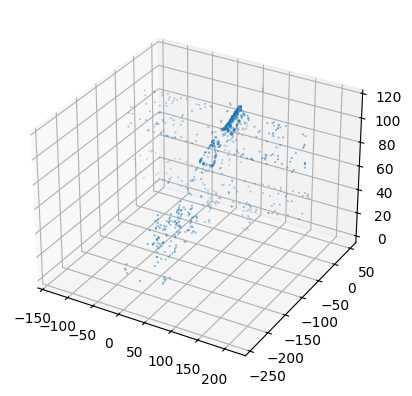

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*train[0].pos.T,s=0.1)

In [ ]:
train_loader = DataLoader(train, batch_size=1, shuffle=False)
j=0
for batch in tqdm(train_loader,smoothing=0.0,dynamic_ncols=True):
    with torch.no_grad():
        out=model(batch.cuda())
    j+=1

In [ ]:
train_loader = DataLoader(train, batch_size=2, shuffle=False)
j=0
for batch in tqdm(train_loader,smoothing=0.0,dynamic_ncols=True):
    with torch.no_grad():
        out=model(batch.cuda())
    j+=1

In [ ]:
train_loader = DataLoader(train, batch_size=32, shuffle=False)
j=0
for batch in tqdm(train_loader,smoothing=0.0,dynamic_ncols=True):
    with torch.no_grad():
        out=model(batch.cuda())
    j+=1

In [11]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [14]:
len(test),len(train)

(2468, 9843)

In [ ]:
import numpy as np
BATCH_SIZE=20
N_CLASSES=40
N_EPOCHS=100
N_mols=len(train)
long_bar=tqdm(range(N_EPOCHS*N_mols//BATCH_SIZE),smoothing=0)
e_bar=tqdm(range(N_mols//BATCH_SIZE),smoothing=0)
Q=100000
N_TRAINING_MODEL=len(models)
for model in models:
    model.inner=model.inner.train()
    model.stopped=False
_test_bl = DataLoader(test, batch_size=BATCH_SIZE)
lossfn = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
#torch.autograd.set_detect_anomaly(True)
for epoch in range(N_EPOCHS):
    e_bar.refresh()
    e_bar.reset(N_mols//BATCH_SIZE)
    train_bl=DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    for i, batch in zip(range(N_mols//BATCH_SIZE), train_bl):
        long_bar.update(1)
        e_bar.update(1)
        try:
            batch=(batch.to(cuda))
            
            for model in models:
                if model.stopped or not model.training: continue
                model.inner=model.inner.train()
                out = model.inner(batch)
                loss = lossfn(out, batch.y)#-((nn.functional.one_hot(batch.y, N_CLASSES)*N_CLASSES-1)/N_CLASSES*out).mean()
                model.inner.zero_grad(set_to_none=True)
                
                if model.total_iters<5:
                    model.running_loss = model.running_loss*.3+loss.item()*.7
                else:
                    model.running_loss = model.running_loss*(1-1/100)+loss.item()/100
                    
                if model.total_iters+.2>1.1**len(model.train_loss_record):
                    model.train_loss_record[model.total_iters]=model.running_loss
                loss.backward()
                model.optim.step()
                model.total_iters+=1

            ### evaluation
            if i%512==0:
                for model in models:
                    if model.stopped or not model.training: continue
                    model.inner=model.inner.eval()
                    L=len(test)
                    test_bl=iter(_test_bl)
                    model.test_loss_record[model.total_iters]=0
                    for batch in test_bl:
                        batch=(batch.to(cuda))
                        with torch.no_grad():
                            out = model.inner(batch)
                        model.results=out.view(-1).tolist()
                        #loss = -((nn.functional.one_hot(batch.y, N_CLASSES)*N_CLASSES-1)/N_CLASSES*out).sum().detach().item()
                        accuracy = (out.argmax(-1)==batch.y).float().sum()
                        model.test_loss_record[model.total_iters]+=-accuracy/L
                    
                    if model.test_loss_record[model.total_iters]<model.best_eval_loss:
                        model.best_eval_loss=model.test_loss_record[model.total_iters]
                        if model.total_iters>10000:
                            model.save()
                        #if np.log10(loss/models[model_name]['best_eval_loss'])>1.5 and models[model_name]['total_iters']>100:
                        #    models[model_name]['stopped']=True
                        #    N_TRAINING_MODEL-=1
                    
            ###logging
            logstr=''
            for model in models:
                if model.stopped:
                    logstr+=f'{model.name}(stopped):{int(Q*model.running_loss)/Q}({int(Q*model.best_eval_loss)/Q}). '
                else:
                    logstr+=f'{model.name}:{int(Q*model.running_loss)/Q}({int(Q*model.best_eval_loss)/Q}). '
            e_bar.set_description(logstr)
        except Exception as e:
            raise e
    ### stepping schedulers:
    
    for model in models:
        if model.sched is None: continue
        if model.stopped or not model.training: continue
        model.inner=model.inner.eval()
        L=len(test)
        test_bl=iter(_test_bl)
        total_eval_loss=0
        for batch in test_bl:
            batch=(batch.to(cuda))
            with torch.no_grad():
                out = model.inner(batch)#X, A, E, batch=b)
            #loss = -((nn.functional.one_hot(batch.y, N_CLASSES)*N_CLASSES-1)/N_CLASSES*out).sum().detach().item()
            accuracy = (out.argmax(-1)==batch.y).float().sum()
            total_eval_loss+=-accuracy/L
        model.sched.step()

  0%|          | 0/49215 [00:00<?, ?it/s]

  0%|          | 0/492 [00:00<?, ?it/s]

In [11]:

test_bl=iter(_test_bl)
total_eval_loss=0
for batch in test_bl:
    batch=(batch.to(cuda))
    with torch.no_grad():
        out = model.inner(batch)#X, A, E, batch=b)
    loss = -((nn.functional.one_hot(batch.y, N_CLASSES)*2-1)*out).sum().detach().item()

    break

In [28]:
import pandas as pd
newd={}
for k,v in (model.test_loss_record).items():
    newd[k]=v.item()
newd=-pd.Series(newd)
newd2=pd.Series(model.train_loss_record)

In [32]:
import torch

def compute_structure_vectors(points: torch.Tensor):
    """
    Args:
        points: (N, 3) tensor of 3D points

    Returns:
        L: (3,) principal direction vector scaled by linearity strength
        P: (3,) normal vector scaled by planarity strength
        U: (3, 3) matrix of eigenvectors (columns)
        lambdas: (3,) eigenvalues in descending order
    """
    # 1. Center the points (permutation-invariant)
    centroid = points.mean(dim=0, keepdim=True)
    centered = points - centroid  # (N, 3)

    # 2. Compute covariance matrix
    cov = centered.T @ centered / points.shape[0]  # (3, 3)

    # 3. Eigen-decomposition (symmetric matrix → use eigh)
    lambdas, U = torch.linalg.eigh(cov)  # ascending order

    # 4. Sort eigenvalues/eigenvectors in descending order
    idx = torch.argsort(lambdas, descending=True)
    lambdas = lambdas[idx]
    U = U[:, idx]  # eigenvectors as columns

    # 5. Compute L and P vectors
    linearity_strength = lambdas[0] - lambdas[1]
    planarity_strength = lambdas[1] - lambdas[2]

    L = U[:, 0] * linearity_strength  # dominant direction
    P = U[:, 2] * planarity_strength  # normal to best-fit plane

    return L, P, U, lambdas


In [46]:
X=torch.randn(100,1).repeat(1,2)
average_line_vector(X)

tensor([-1.3834, -1.3834])

In [44]:
X=torch.randn(100,2)
X[:,0]=0
average_line_vector(X)

tensor([0.0000, 0.9495])

In [70]:
X=torch.randn(10000,3)
X[:,1]=X[:,1]/10
t=0
n=1000
for _ in range(n):
    t=t+average_line_vector(X)
print(t/n)

tensor([2.4937e-02, 1.1589e-05, 2.1488e-02])


In [67]:
t/1000

tensor([-2.2517e-02, -1.3566e-05,  1.0602e-02])

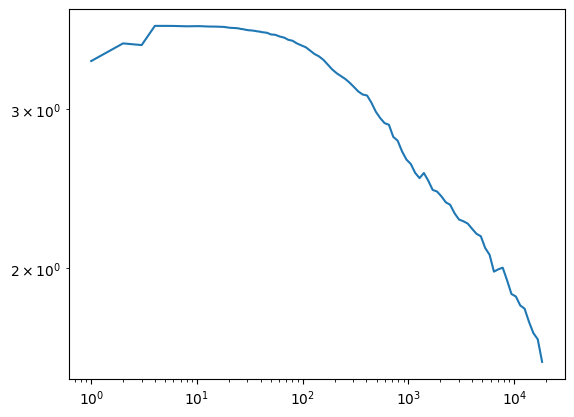

In [31]:
newd2.plot()
plt.xscale('log')
plt.yscale('log')

In [35]:
tmp=((out/out.mean()))
tmp=tmp-tmp.min()
tmp=tmp/tmp.max()
tmp=(tmp*10).int()
tmp

tensor([[ 1,  8,  1,  6,  1,  3,  9,  6,  0,  6,  9,  7,  5,  8,  5,  7,  6,  7,
          7,  7,  7,  4,  2,  5,  9,  5,  5,  8,  8,  7,  0,  8,  9,  2,  7,  3,
          4,  2,  9,  8],
        [ 1,  8,  1,  6,  1,  3,  9,  6,  0,  6,  9,  7,  5,  8,  5,  7,  6,  7,
          7,  7,  7,  4,  1,  5,  9,  5,  5,  8,  8,  7,  0,  8,  9,  2,  7,  3,
          4,  2,  9,  8],
        [ 1,  8,  1,  6,  1,  3,  9,  6,  0,  6,  9,  7,  5,  8,  5,  7,  6,  7,
          7,  7,  7,  4,  1,  5,  9,  5,  5,  8,  8,  7,  0,  8,  9,  2,  7,  3,
          4,  2,  9,  8],
        [ 1,  8,  1,  6,  1,  3,  9,  6,  0,  6,  9,  7,  5,  8,  5,  7,  6,  7,
          7,  7,  7,  4,  1,  5,  9,  5,  5,  8,  8,  7,  0,  8,  9,  2,  7,  3,
          4,  2,  9,  8],
        [ 1,  8,  1,  6,  1,  3,  9,  6,  0,  6,  9,  7,  5,  8,  5,  7,  6,  7,
          7,  7,  7,  4,  1,  5,  9,  5,  5,  8,  8,  7,  0,  8,  9,  2,  7,  3,
          4,  2,  9,  8],
        [ 1,  8,  1,  6,  1,  3,  9,  6,  0,  6,  9,  7,  5,

In [15]:
batch.y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')

In [37]:
batch.y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')

In [79]:
model(batch).shape

 PointCloudClassifier V: torch.Size([1042, 33]) std: tensor(0.5694, device='cuda:0', grad_fn=<StdBackward0>)
 PointCloudClassifier V: torch.Size([31, 33]) std: tensor(0.4941, device='cuda:0', grad_fn=<StdBackward0>)


torch.Size([31, 40])

In [75]:
batch

DataBatch(y=[32], pos=[94742, 3], batch=[94742], ptr=[33])

In [66]:
(nn.functional.one_hot(batch.y, N_CLASSES)*2-1).shape

torch.Size([32, 40])

In [45]:
K=_batch.pos
batch=_batch.batch
if batch is None:
    batch = torch.zeros(K.shape[0],dtype=torch.long,device=K.device)
assert batch.dtype == torch.long
assert batch.dim() == 1
assert batch.min() >= 0
if K.shape[0]>2000:#if point cloud is too big, subsample it uniformly
    print("K:",K.shape,K.min().item(),'->',K.max().item())#K: torch.Size([2755, 3]) -73.44438171386719 -> 73.44438171386719
    print("batch:",batch.shape,batch.min().item(),'->',batch.max().item())#batch: torch.Size([2755]) 0 -> 1
    # K: torch.Size([2755, 3]) -73.44438171386719 -> 73.44438171386719
    # batch: torch.Size([2755]) 0 -> 1
    sampled_idx = fps(K, ratio=1024/K.shape[0], batch=batch, random_start=True)#sample 1024 points, the dataset is raw ModelNet40 .off files
    print("older sampled_idx:",sampled_idx.shape,sampled_idx.min().item(),'->',sampled_idx.max().item())
    # older sampled_idx: torch.Size([1025]) 0 -> 2754
    

    assert sampled_idx.max().item() < K.shape[0]
    assert sampled_idx.max().item() < batch.shape[0]
    assert sampled_idx.min().item() >= 0
    assert sampled_idx.numel() > 0
    # ensure at least one neighbor per sampled node
    edge_idx = knn(K[sampled_idx], K, 1,
                   batch_x=batch[sampled_idx], batch_y=batch).flip(0)
    #for each point, find the closest sampled point
    #note: knn returns tgt, src (so edge_idx is flipped over the 0th axis to get src, tgt)
    #edge_idx: torch.Size([2, 2755]) 0 -> 2754
    rand_tmp = torch.rand(edge_idx.size(1), device=K.device)
    print("rand_tmp:",rand_tmp.shape,rand_tmp.min().item(),'->',rand_tmp.max().item())
    print("edge_idx.size(0):",edge_idx.size(0))
    print("edge_idx.size(1):",edge_idx.size(1))
    print("rand_tmp.size(0):",rand_tmp.size(0))
    print("rand_tmp:",rand_tmp)
    print("edge_idx[0]:",edge_idx[0])
    # rand_tmp: torch.Size([2755]) 9.066204074770212e-05 -> 0.9996086359024048
    # edge_idx.size(0): 2
    # edge_idx.size(1): 2755
    # rand_tmp.size(0): 2755
    # rand_tmp: tensor([0.0268, 0.2423, 0.6176,  ..., 0.8445, 0.4571, 0.3178], device='cuda:0')
    # edge_idx[0]: tensor([  1,   4,   7,  ..., 991, 987, 864], device='cuda:0')
    _, newer_sampled_idx = scatter_min(rand_tmp,
                                 edge_idx[0], dim=0)# for each sampled point, pick a random point from all points whose closest sampled point is itself. this is to fight the edge-bias in FPS sampling
    final_sampled_idx = edge_idx[0][newer_sampled_idx[newer_sampled_idx<edge_idx.shape[1]]]
    print("val:",val.shape,val.min().item(),'->',val.max().item())
    print("edge_idx:",edge_idx.shape,edge_idx.min().item(),'->',edge_idx.max().item())
    print("newer_sampled_idx:",newer_sampled_idx.shape,newer_sampled_idx.min().item(),'->',newer_sampled_idx.max().item())
    print("final_sampled_idx:",final_sampled_idx.shape,final_sampled_idx.min().item(),'->',final_sampled_idx.max().item())
    #val: torch.Size([1025]) 0.0 -> 0.9908497929573059 
    #edge_idx: torch.Size([2, 2755]) 0 -> 2754 
    #newer_sampled_idx: torch.Size([1025]) 0 -> 2755 problem is here, how is the argmin output of scatter_min larger than both its args' 0th dim (in 0-indexing-speak)?
    
    assert final_sampled_idx.max().item() < K.shape[0]
    #^assert raised, because newer newer_sampled_idx's max is 2755
    assert final_sampled_idx.max().item() < batch.shape[0]
    assert final_sampled_idx.min().item() >= 0
    assert final_sampled_idx.numel() > 0


    K=K[final_sampled_idx]
    batch=batch[final_sampled_idx]

K: torch.Size([2755, 3]) -73.44438171386719 -> 73.44438171386719
batch: torch.Size([2755]) 0 -> 1
older sampled_idx: torch.Size([1025]) 0 -> 2754
rand_tmp: torch.Size([2755]) 2.0749750547111034e-05 -> 0.9999164342880249
edge_idx.size(0): 2
edge_idx.size(1): 2755
rand_tmp.size(0): 2755
rand_tmp: tensor([0.2651, 0.9313, 0.7658,  ..., 0.3116, 0.4726, 0.2564], device='cuda:0')
edge_idx[0]: tensor([ 14,   3,   1,  ..., 991, 989, 890], device='cuda:0')
val: torch.Size([1025]) 0.0 -> 0.9908497929573059
edge_idx: torch.Size([2, 2755]) 0 -> 2754
newer_sampled_idx: torch.Size([1025]) 8 -> 2755
final_sampled_idx: torch.Size([929]) 0 -> 1024


In [54]:
tmp=newer_sampled_idx[(0<=newer_sampled_idx)&(newer_sampled_idx<edge_idx.shape[1])]
print("tmp:",tmp.shape,tmp.min().item(),'->',tmp.max().item())

tmp: torch.Size([929]) 8 -> 2752


In [51]:
newer_sampled_idx.max()

tensor(2755, device='cuda:0')

In [53]:
edge_idx.shape

torch.Size([2, 2755])

In [36]:
import pandas as pd
tmp=pd.Series(scatter_min(rand_tmp,edge_idx[0], dim=0)[1].cpu())

In [33]:
edge_idx[0].unique()

tensor([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
          24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
          36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,   47,
          48,   49,   50,   51,   52,   53,   54,   55,   56,   57,   58,   59,
          60,   61,   62,   63,   64,   65,   66,   67,   68,   69,   70,   71,
          72,   73,   74,   75,   76,   77,   78,   79,   80,   81,   82,   83,
          84,   85,   86,   87,   88,   89,   90,   91,   92,   93,   94,   95,
          96,   97,   98,   99,  100,  101,  102,  103,  104,  105,  106,  107,
         108,  109,  110,  111,  112,  113,  114,  115,  116,  117,  118,  119,
         120,  121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
         132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,  143,
         144,  145,  146,  147,  148,  1

In [35]:
1024-929

95

In [34]:
edge_idx[0].unique().shape

torch.Size([929])

In [40]:
tmp.value_counts()

2755    96
77       1
1402     1
1190     1
2713     1
        ..
117      1
119      1
68       1
167      1
1996     1
Name: count, Length: 930, dtype: int64

In [18]:
sampled_idx.max(),newer_sampled_idx.max()

(tensor(2754, device='cuda:0'), tensor(2755, device='cuda:0'))

In [77]:
rand_tmp.min(),val[newer_sampled_idx.argmax()]

(tensor(0.0003, device='cuda:0'), tensor(0., device='cuda:0'))

In [23]:
edge_idx.max(1).values

tensor([1024, 2754], device='cuda:0')

In [81]:
K

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [35]:

with torch.no_grad():
    out=model(e.cuda())

PointCloudClassifier a
PointCloudClassifier V: torch.Size([1024, 32])
  UNet down...
   V: torch.Size([1024, 32]) tensor(0., device='cuda:0')
   h_target: torch.Size([103, 32]) tensor(0., device='cuda:0')
   edge_index: torch.Size([2, 5120])
   edge_attr: torch.Size([5120, 32]) tensor(0.0623, device='cuda:0')
    ConvLayer edge_attr: torch.Size([5120, 32]) tensor(0.6850, device='cuda:0')
    ConvLayer h0: torch.Size([103, 32]) tensor(0., device='cuda:0')
    ConvLayer self.alpha: torch.Size([32]) tensor(0.8000, device='cuda:0')
    ConvLayer out: torch.Size([103, 32]) tensor(0.6369, device='cuda:0')
   Δh: torch.Size([103, 32]) tensor(0.6369, device='cuda:0')
  down norm V_/std: torch.Size([103, 32]) / tensor(0., device='cuda:0')
  UNet down...
   V: torch.Size([103, 32]) tensor(0.6368, device='cuda:0')
   h_target: torch.Size([26, 32]) tensor(0., device='cuda:0')
   edge_index: torch.Size([2, 515])
   edge_attr: torch.Size([515, 32]) tensor(0.0479, device='cuda:0')
    ConvLayer edge_

tensor([[ 0.0623,  0.0289, -0.1476,  0.6200,  0.8131, -0.2223,  0.1217, -1.0471,
         -0.6724,  0.6702,  0.4689,  0.4061, -0.2864,  0.6696,  0.0085,  0.1255,
          0.6218,  0.4721,  0.0220, -0.0719, -0.2046,  0.6348, -0.0732,  0.2533,
         -0.2478, -0.4687, -0.2923,  0.9369,  0.6836, -0.8164,  0.3421,  0.1981]],
       device='cuda:0')

In [22]:
i=1
for batch in train_loader:
    with torch.no_grad():
        out=model(batch.cuda())
    i-=1
    if i<=0: break

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [65]:
import gc
gc.collect()
torch.cuda.empty_cache()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [15]:
out.shape,batch

(torch.Size([3, 64]), DataBatch(y=[3], pos=[22973, 3], batch=[22973], ptr=[4]))

In [17]:
out

tensor([[ 0.0846,  0.2437,  0.4930,  0.5731, -0.4289, -0.3177, -1.1218, -0.4881,
         -0.5131,  0.4151,  0.3612, -0.1624,  0.8598, -0.5200,  0.6610,  0.2913,
          0.0747, -0.2293, -0.7240, -0.5975, -0.0671,  0.1689,  0.4994,  0.1054,
         -0.5291,  0.6520,  0.2644,  0.6395, -0.3990,  0.2731, -0.1127, -0.9938,
          0.1512,  0.7586,  0.0016,  0.4451,  0.4444, -0.9466, -0.0186, -0.0166,
          0.1230, -0.1883, -0.4473,  0.1235,  0.2731, -0.4710,  0.6529, -0.8307,
         -0.7177,  0.0408,  0.3225, -0.2626, -0.6011, -0.2693, -0.7528, -0.0079,
         -0.2458,  0.3422, -0.1566,  0.5267,  0.0234,  0.1355, -0.2149,  0.1233],
        [ 0.3997,  0.1986,  0.5120,  0.6227, -0.1467, -0.1928, -0.9584, -0.3459,
         -0.4417,  0.4930,  0.1917, -0.2493,  1.0093, -0.4703,  0.4498,  0.2807,
         -0.0018, -0.1181, -0.7682, -0.4893, -0.1825, -0.0344,  0.6766, -0.0524,
         -0.7310,  0.5407, -0.0073,  0.6747, -0.3235,  0.3079, -0.2274, -0.8716,
          0.2074,  0.6266, 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def clone_array(x):
    if hasattr(x, 'clone'):
        return x.clone()
    elif hasattr(x, 'copy'):
        return x.copy()
    elif type(x).__module__.startswith("tensorflow"):
        import tensorflow as tf
        return tf.identity(x)
    else:
        raise TypeError(f"Cannot clone object of type {type(x)}")


In [3]:
def xavier_uniform(fan_in, fan_out):
    """Xavier/Glorot Uniform Initialization"""
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, size=(fan_in, fan_out))

def xavier_normal(fan_in, fan_out):
    """Xavier/Glorot Normal Initialization"""
    std = np.sqrt(2 / (fan_in + fan_out))
    return np.random.randn(fan_in, fan_out) * std

def he_uniform(fan_in, fan_out):
    """He Uniform Initialization (for ReLU)"""
    limit = np.sqrt(6 / fan_in)
    return np.random.uniform(-limit, limit, size=(fan_in, fan_out))

def he_normal(fan_in, fan_out):
    """He Normal Initialization (for ReLU)"""
    std = np.sqrt(2 / fan_in)
    return np.random.randn(fan_in, fan_out) * std

def init_linear_layer(fan_in, fan_out, method='he_normal'):
    if method == 'he_normal':
        W = he_normal(fan_in, fan_out)
    elif method == 'he_uniform':
        W = he_uniform(fan_in, fan_out)
    elif method == 'xavier_normal':
        W = xavier_normal(fan_in, fan_out)
    elif method == 'xavier_uniform':
        W = xavier_uniform(fan_in, fan_out)
    else:
        raise ValueError("Unknown init method")
    
    b = np.zeros(fan_out)  # Standard to init biases to zero
    return W, b

In [14]:
def SELU(x):
    L=1.0507
    A=1.6733
    y=clone_array(x)
    y[y>0]=L*y[y>0]
    y[y<=0]=L*A*((y[y<=0]).exp()-1)
    return y

In [15]:
def ReLU(x):
    y=clone_array(x)
    y[y<=0]=0
    return y

In [16]:
def SiLU(x):
    return x*(1/(-x).exp())

In [13]:
torch.tensor(2).exp

<function Tensor.exp>

In [19]:
import torch
from torch import nn
from torch.nn.init import kaiming_uniform_, xavier_normal_, xavier_uniform_

torch.manual_seed(0)

dim = 32
depth = 100
x = torch.randn(100, dim).cuda()

layers = []

for _ in range(depth):
    layer = nn.Linear(dim, dim, bias=False).cuda()
    xavier_uniform_(layer.weight)  # apply proper init
    layers.append(layer)

# Forward pass
with torch.no_grad():
    for i, layer in enumerate(layers):
        act=nn.functional.selu
        x = act(layer(x))#.relu()*1.03
        #/print(f'Layer {i+1} std: {x.std().cpu().numpy()}')


Layer 1 std: 1.0115141868591309
Layer 2 std: 1.0234248638153076
Layer 3 std: 1.022629976272583
Layer 4 std: 0.9998650550842285
Layer 5 std: 0.9679993987083435
Layer 6 std: 1.0320063829421997
Layer 7 std: 0.9962770938873291
Layer 8 std: 0.9833673238754272
Layer 9 std: 1.0106019973754883
Layer 10 std: 0.987510085105896
Layer 11 std: 0.970865786075592
Layer 12 std: 0.922020673751831
Layer 13 std: 1.0506401062011719
Layer 14 std: 1.1412053108215332
Layer 15 std: 1.1503292322158813
Layer 16 std: 1.0887736082077026
Layer 17 std: 1.0316565036773682
Layer 18 std: 1.0803827047348022
Layer 19 std: 1.0234907865524292
Layer 20 std: 1.0064483880996704
Layer 21 std: 1.0660984516143799
Layer 22 std: 1.1832232475280762
Layer 23 std: 1.2145192623138428
Layer 24 std: 1.2397723197937012
Layer 25 std: 1.1366950273513794
Layer 26 std: 1.0359729528427124
Layer 27 std: 0.9909015893936157
Layer 28 std: 1.0834981203079224
Layer 29 std: 1.097040057182312
Layer 30 std: 1.0451890230178833
Layer 31 std: 0.95022338

In [119]:
import numpy as np
import torch
import random
from torch import nn

# Use this if the class is not imported
class OnlineQuantileEstimator(nn.Module):
    def __init__(self, quantile=0.95, lr=0.01, init_estimate=0.0):
        super().__init__()
        assert 0.0 < quantile < 1.0, "Quantile must be in (0, 1)"
        self.register_buffer('estimate', torch.tensor(float(init_estimate)))
        self.register_buffer('count', torch.tensor(0, dtype=torch.long))
        self.quantile = quantile
        self.lr = lr

    def update(self, x: torch.Tensor):
        x = x.flatten()
        estimate = self.estimate

        for value in x:
            direction = (self.quantile - (value < estimate).float())
            estimate = estimate + self.lr * direction
            self.count += 1

        self.estimate = estimate.detach()

    def forward(self):
        return self.estimate

    def extra_repr(self):
        return f"quantile={self.quantile}, lr={self.lr}, estimate={self.estimate.item():.4f}, count={self.count.item()}"


def test_online_quantile(q=None):
    np.random.seed(42)
    data = np.random.normal(loc=0, scale=1, size=3000).tolist()
    data += [-10, -8, 8, 12]
    random.shuffle(data)
    if q is None:
        q = torch.rand([]).item()
    estimator = OnlineQuantileEstimator(quantile=q, lr=0.01, init_estimate=0.0)

    for x in data:
        estimator.update(torch.tensor([x], dtype=torch.float32))

    est_q = estimator().item()
    true_q = np.quantile(data, q)

    print(f"Absolute error: {abs(est_q - true_q):.4f}")
    print(f"Relative error: {int(100*abs(est_q - true_q)/abs(true_q))}%")

    # Check serialization
    state = estimator.state_dict()
    param_count = sum(p.numel() for p in estimator.parameters())
    new_estimator = OnlineQuantileEstimator(quantile=q, lr=0.01, init_estimate=0.0)
    new_estimator.load_state_dict(state)

    est_q_loaded = new_estimator().item()
    assert abs(est_q - est_q_loaded) < 1e-6, "Serialization failed"


if __name__ == "__main__":
    for i in range(100):
        q=i/300+2/3
        print(' === q',q,'===')
        test_online_quantile()


 === q 0.6666666666666666 ===
Absolute error: 0.0245
Relative error: 1%
 === q 0.6699999999999999 ===
Absolute error: 0.4597
Relative error: 17%
 === q 0.6733333333333333 ===
Absolute error: 0.0424
Relative error: 43%
 === q 0.6766666666666666 ===
Absolute error: 0.0107
Relative error: 1%
 === q 0.6799999999999999 ===
Absolute error: 0.0758
Relative error: 38%
 === q 0.6833333333333333 ===
Absolute error: 0.0349
Relative error: 2%
 === q 0.6866666666666666 ===
Absolute error: 0.0364
Relative error: 2%
 === q 0.69 ===
Absolute error: 0.0812
Relative error: 4%
 === q 0.6933333333333332 ===
Absolute error: 0.0095
Relative error: 1%
 === q 0.6966666666666667 ===
Absolute error: 0.0568
Relative error: 106%
 === q 0.7 ===
Absolute error: 0.1309
Relative error: 36%
 === q 0.7033333333333333 ===
Absolute error: 0.0132
Relative error: 6%
 === q 0.7066666666666667 ===
Absolute error: 0.0144
Relative error: 5%
 === q 0.71 ===
Absolute error: 0.0333
Relative error: 1%
 === q 0.7133333333333333 ===